In [4]:
# pip install scikit-learn

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC as SVMClassifier
from tools.preprocess import load_datasets, preprocess_hepatitis_datasets
from tools.distance import ManhattanDistance, EuclideanDistance, CosineDistance
from tools.voting import MajorityClassVote, InverseDistanceWeightedVote, ShepardsWorkVote
from tools.knn import KNNClassifier
from tools.metrics import cross_validate
from tools.reduction import reductionKNNAlgorithm
import itertools
from functools import partial
import logging

logging.basicConfig(level=logging.ERROR, format="%(levelname)s - %(message)s")
logger = logging.getLogger()

In [8]:
train_dfs = load_datasets("datasetsCBR/hepatitis/hepatitis.fold.*.train.arff")
test_dfs = load_datasets("datasetsCBR/hepatitis/hepatitis.fold.*.test.arff")

print(f"\nNumber of training dataframes: {len(train_dfs)}")
print(f"Number of test dataframes: {len(test_dfs)}")
print()
train_dfs[0].head()


Number of training dataframes: 10
Number of test dataframes: 10



,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,38.0,b'female',b'no',b'no',b'yes',b'yes',b'yes',b'yes',b'yes',b'no',b'yes',b'yes',b'yes',1.2,118.0,16.0,2.8,NaN,b'yes',b'DIE'
1,54.0,b'female',b'no',b'no',b'yes',b'yes',b'no',b'yes',b'no',b'no',b'no',b'yes',b'no',1.2,85.0,92.0,3.1,66.0,b'yes',b'LIVE'
2,58.0,b'male',b'yes',b'no',b'yes',b'no',b'no',b'yes',b'yes',b'no',b'yes',b'no',b'no',1.4,175.0,55.0,2.7,36.0,b'no',b'LIVE'
3,23.0,b'female',b'yes',b'no',b'no',b'no',b'no',b'?',b'?',b'?',b'?',b'?',b'?',4.6,56.0,16.0,4.6,NaN,b'no',b'LIVE'
4,31.0,b'female',b'yes',b'no',b'no',b'no',b'no',b'yes',b'no',b'no',b'no',b'no',b'no',1.0,85.0,20.0,4.0,100.0,b'no',b'LIVE'


In [10]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                  0
SEX                  0
STEROID              0
ANTIVIRALS           0
FATIGUE              0
MALAISE              0
ANOREXIA             0
LIVER_BIG            0
LIVER_FIRM           0
SPLEEN_PALPABLE      0
SPIDERS              0
ASCITES              0
VARICES              0
BILIRUBIN           60
ALK_PHOSPHATE      290
SGOT                40
ALBUMIN            160
PROTIME            670
HISTOLOGY            0
Class                0
dtype: int64

In [11]:
for df in train_dfs + test_dfs:
    preprocess_hepatitis_datasets(df)

train_dfs[0].head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,16,0,1,0,2,2,2,2,2,1,2,2,2,-0.196888,0.326094,-0.783694,-1.634904,0.000000,1,1
1,32,0,1,0,2,2,1,2,1,1,1,2,1,-0.196888,-0.407907,0.063288,-1.150583,0.304587,1,0
2,35,1,2,0,2,1,1,2,2,1,2,1,1,-0.027589,1.593914,-0.349059,-1.796345,-1.441041,0,0
3,3,0,2,0,1,1,1,0,0,0,0,0,0,2.681185,-1.052938,-0.783694,1.271023,0.000000,0,0
4,10,0,2,0,1,1,1,2,1,1,1,1,1,-0.366186,-0.407907,-0.739116,0.302380,2.282966,0,0


In [12]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                0
SEX                0
STEROID            0
ANTIVIRALS         0
FATIGUE            0
MALAISE            0
ANOREXIA           0
LIVER_BIG          0
LIVER_FIRM         0
SPLEEN_PALPABLE    0
SPIDERS            0
ASCITES            0
VARICES            0
BILIRUBIN          0
ALK_PHOSPHATE      0
SGOT               0
ALBUMIN            0
PROTIME            0
HISTOLOGY          0
Class              0
dtype: int64

In [13]:
k_values = [1, 3, 5, 7]
distance_funcs = [ManhattanDistance(), EuclideanDistance(), CosineDistance()]
voting_funcs = [MajorityClassVote(), InverseDistanceWeightedVote(), ShepardsWorkVote()]

results = pd.DataFrame(
    columns=[
        "k",
        "distance_func",
        "voting_func",
        "f1_mean",
        "f1_std",
    ]
)
for k, distance_func, voting_func in itertools.product(
    k_values, distance_funcs, voting_funcs
):
    knn = KNNClassifier(
        k=k,
        distance_func=distance_func,
        voting_func=voting_func,
        weights=np.ones(len(train_dfs[0].columns) - 1),
    )
    scores = cross_validate(
        knn,
        train_dfs,
        test_dfs,
        target_col="Class",
        score_func=partial(f1_score, average="weighted"),
    )
    results.loc[len(results)] = [
        k,
        distance_func.__class__.__name__,
        voting_func.__class__.__name__,
        scores.mean(),
        scores.std(),
    ]

results.sort_values(by="f1_mean", ascending=False)

,k,distance_func,voting_func,f1_mean,f1_std
0,1,ManhattanDistance,MajorityClassVote,0.895644,0.038203
2,1,ManhattanDistance,ShepardsWorkVote,0.895644,0.038203
1,1,ManhattanDistance,InverseDistanceWeightedVote,0.895644,0.038203
9,3,ManhattanDistance,MajorityClassVote,0.890016,0.022913
3,1,EuclideanDistance,MajorityClassVote,0.885637,0.016477
4,1,EuclideanDistance,InverseDistanceWeightedVote,0.885637,0.016477
5,1,EuclideanDistance,ShepardsWorkVote,0.885637,0.016477
30,7,EuclideanDistance,MajorityClassVote,0.884946,0.016554
18,5,ManhattanDistance,MajorityClassVote,0.884946,0.016554
21,5,EuclideanDistance,MajorityClassVote,0.884348,0.016290


In [ ]:
## best ManhattanDistance k=7(?)

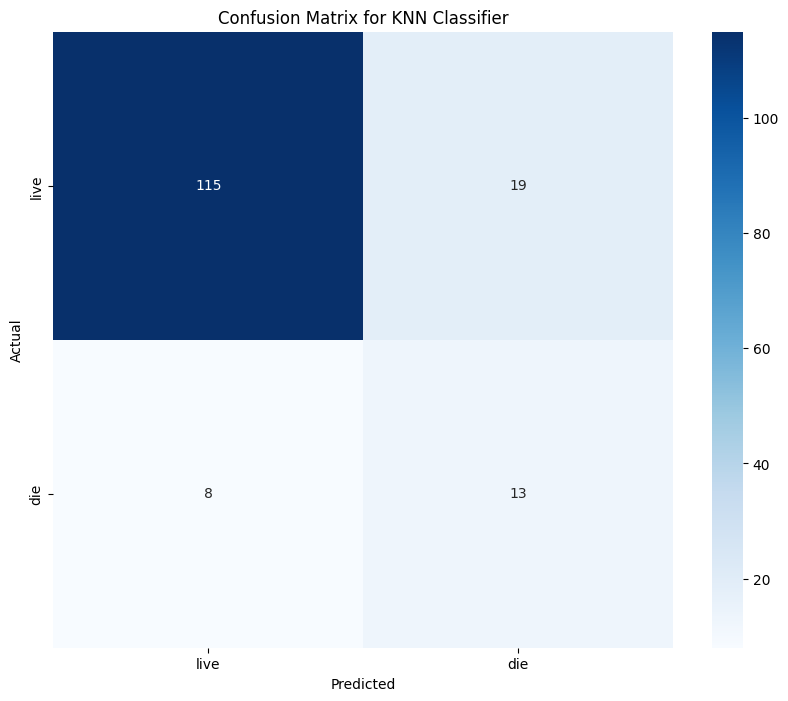

In [14]:
knn = KNNClassifier(
    k=7,
    distance_func=ManhattanDistance(),
    voting_func=InverseDistanceWeightedVote(),
    weights=np.ones(len(train_dfs[0].columns) - 1),
)
scores = cross_validate(
    knn,
    train_dfs,
    test_dfs,
    target_col="Class",
    score_func=partial(confusion_matrix),
)
sum_scores = scores.sum(axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(sum_scores, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for KNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=["live", "die"])
plt.yticks(ticks=[0.5, 1.5], labels=["live", "die"])
plt.show()


In [15]:
c_values = [1, 3, 5, 7]
kernal_types = ["linear", "poly", "rbf", "sigmoid"]

results = pd.DataFrame(
    columns=[
        "c",
        "kernel_type",
        "f1_mean",
        "f1_std",
    ]
)
for c, kernel_type in itertools.product(
    c_values, kernal_types
):
    svm = SVMClassifier(
        C=c,
        kernel=kernel_type,
    )
    scores = cross_validate(
        svm,
        train_dfs,
        test_dfs,
        target_col="Class",
        score_func=partial(f1_score, average="weighted"),
    )
    results.loc[len(results)] = [
        c,
        kernel_type,
        scores.mean(),
        scores.std(),
    ]

results.sort_values(by="f1_mean", ascending=False)

,c,kernel_type,f1_mean,f1_std
0,1,linear,0.909938,0.038576
8,5,linear,0.897346,0.038784
12,7,linear,0.897346,0.038784
14,7,rbf,0.890016,0.022913
4,3,linear,0.888592,0.045727
10,5,rbf,0.885637,0.016477
7,3,sigmoid,0.885395,0.017184
1,1,poly,0.884348,0.016290
2,1,rbf,0.884348,0.016290
3,1,sigmoid,0.884348,0.016290


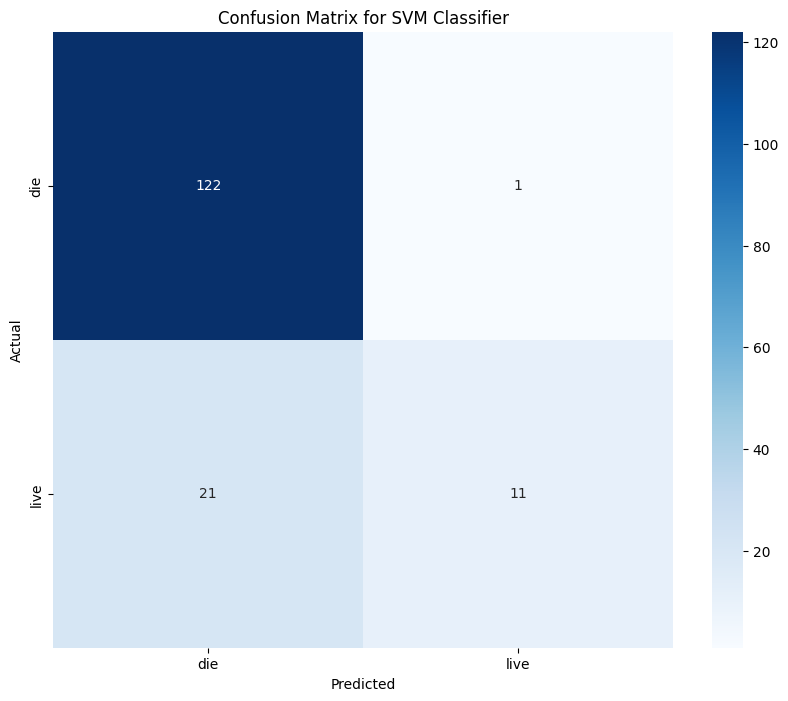

In [16]:
svm = SVMClassifier(
    C=5,
    kernel="linear",
)
y_actuals, y_preds = cross_validate(
        svm,
        train_dfs,
        test_dfs,
    target_col="Class",
)

confusion_matrix = confusion_matrix(y_actuals, y_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for SVM Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.yticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.show()

In [17]:
sensitivity = sum_scores[0, 0] / (sum_scores[0, 0] + sum_scores[1, 0])
specificity = sum_scores[1, 1] / (sum_scores[1, 1] + sum_scores[0, 1])
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Sensitivity: 0.9349593495934959
Specificity: 0.40625


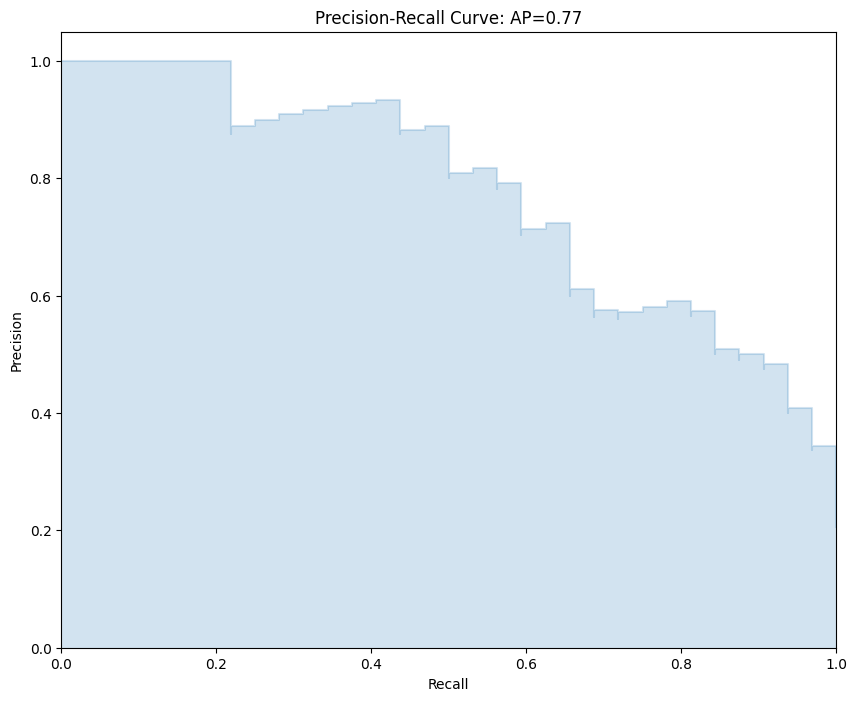

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Create and train the SVM classifier
svm = SVMClassifier(C=5, kernel="linear", probability=True)
y_true, y_scores = cross_validate(svm, train_dfs, test_dfs, "Class", use_proba=True)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])
average_precision = average_precision_score(y_true, y_scores[:, 1])

# Plot the precision-recall curve
plt.figure(figsize=(10, 8))
plt.step(recall, precision, alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: AP={average_precision:.2f}')
plt.show()

In [19]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

# Create and calibrate the SVM classifier
base_svm = SVMClassifier(C=5, kernel="linear")
calibrated_svm = CalibratedClassifierCV(base_svm, cv=5, method='sigmoid')

# Get predictions and true labels
y_true, y_scores = cross_validate(calibrated_svm, train_dfs, test_dfs, "Class", use_proba=True)

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores[:, 1])

# Find the threshold that gives the highest recall while maintaining at least 90% recall
target_recall = 0.9
valid_thresholds = thresholds[:][recall[1:] >= target_recall]
if len(valid_thresholds) > 0:
    recall_threshold = valid_thresholds[-1]
else:
    recall_threshold = thresholds[-1]  # If no threshold gives 90% recall, use the lowest threshold

# Get predictions with the new threshold
y_preds_high_recall = (y_scores[:, 1] >= recall_threshold).astype(int)

# Calculate metrics
high_recall = recall_score(y_true, y_preds_high_recall)
precision = precision_score(y_true, y_preds_high_recall)
f1 = f1_score(y_true, y_preds_high_recall)

print(f"Threshold for high recall: {recall_threshold:.3f}")
print(f"Recall: {high_recall:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1 Score: {f1:.2%}")

# Print classification report for the high-recall model
print(classification_report(y_true, y_preds_high_recall))


Threshold for high recall: 0.177
Recall: 90.62%
Precision: 53.70%
F1 Score: 67.44%
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       123
           1       0.54      0.91      0.67        32

    accuracy                           0.82       155
   macro avg       0.75      0.85      0.77       155
weighted avg       0.88      0.82      0.83       155



## Reduction techinques 

In [ ]:
## best SVM 
svm = SVMClassifier(C=5, kernel="linear", probability=True)
y_true, y_scores = cross_validate(svm, train_dfs, test_dfs, "Class", use_proba=True)

precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])
average_precision = average_precision_score(y_true, y_scores[:, 1])

In [ ]:
## Best kNN


In [ ]:
## reduction
reductionKNNAlgorithm(train_dfs, test_fds

# Pre-Analysis

In [20]:
preds = []
actuals = []

for train_df, test_df in zip(train_dfs, test_dfs):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df.drop("Class", axis=1), train_df["Class"])
    preds.extend(decision_tree.predict(test_df.drop("Class", axis=1)))
    actuals.extend(test_df["Class"])

print(classification_report(actuals, preds))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       123
           1       0.76      0.50      0.60        32

    accuracy                           0.86       155
   macro avg       0.82      0.73      0.76       155
weighted avg       0.86      0.86      0.85       155



It looks like a decision tree is not able to learn the data well, possibly because the 0th class is a minority class.

In [21]:
feature_importances = pd.DataFrame(
    {
        "feature": train_dfs[0].drop("Class", axis=1).columns,
        "importance": decision_tree.feature_importances_,
        "index": range(len(decision_tree.feature_importances_)),
    }
)
top_5_features = feature_importances.sort_values("importance", ascending=False).head(5)
print("Top 5 features:")
top_5_features

Top 5 features:


,feature,importance,index
17,PROTIME,0.304554,17
13,BILIRUBIN,0.175988,13
0,AGE,0.136559,0
16,ALBUMIN,0.107684,16
8,LIVER_FIRM,0.062004,8


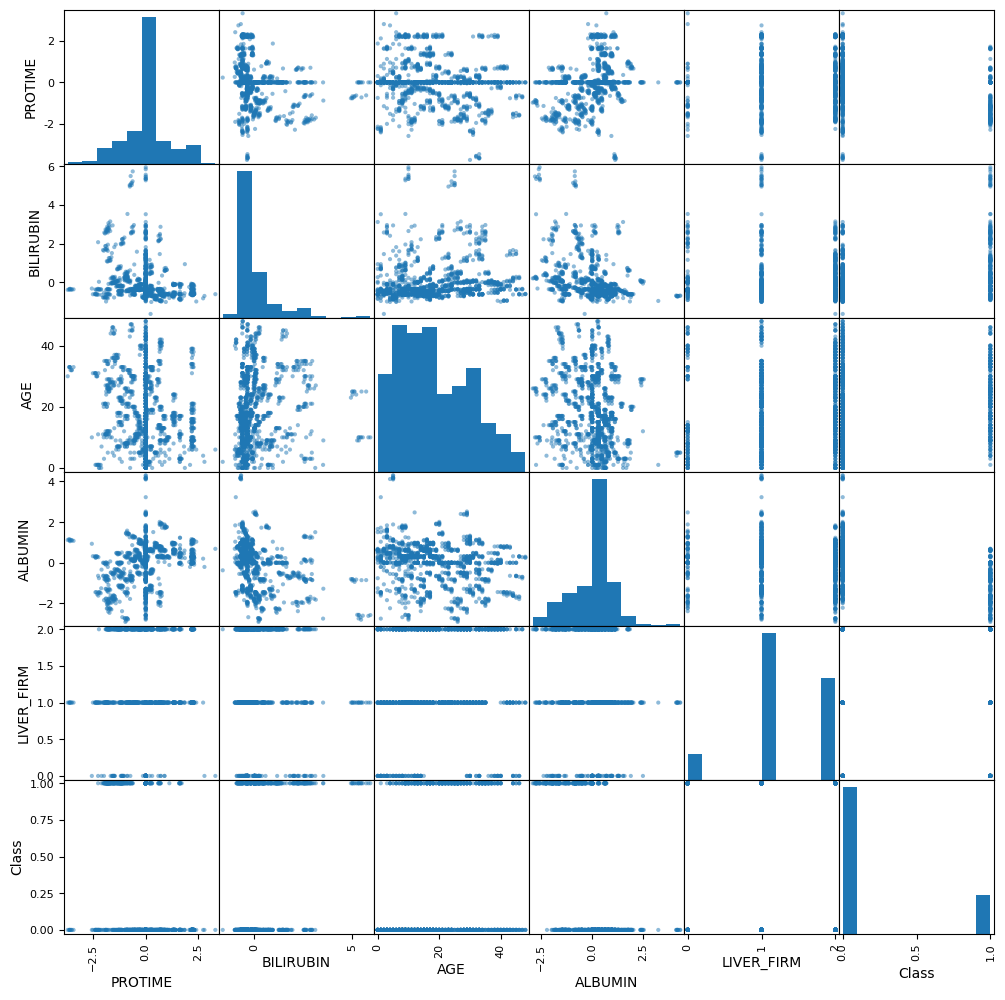

In [22]:
pd.plotting.scatter_matrix(
    pd.concat(train_dfs + test_dfs)[top_5_features.feature.values.tolist() + ["Class"]],
    figsize=(12, 12),
)
plt.show()

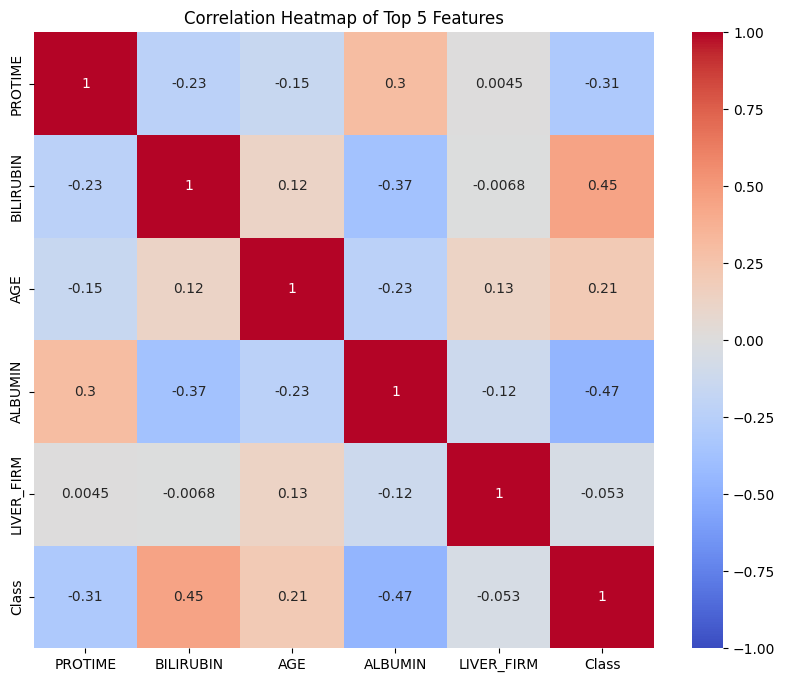

In [23]:
import seaborn as sns

top_5_features_and_class = top_5_features["feature"].tolist() + ["Class"]
corr_matrix = pd.concat(train_dfs + test_dfs)[top_5_features_and_class].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Top 5 Features")
plt.show()